<a href="https://colab.research.google.com/github/cosmaadrian/ml-environment/blob/master/DSM_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSM
## Self-supervised contrastive learning with SimCLR

In this lab, we will explore the implementation of SimCLR, a method for self-supervised pretraining of networks.

We will perform our pretraining on CIFAR10, a dataset of natural images, and then fine tune our network on SVHN, a dataset of pictures of house numbers.

You can find the original paper here: A Simple Framework for Contrastive Learning of Visual Representations (https://arxiv.org/abs/2002.05709)



First off, lets define the training and validation loops for normal, supervised classification.

In [ ]:
import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)


    return epoch_loss

def valid_epoch(model, dataloader, device, criterion, epoch):
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    correct = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()

        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss

def run_training(model, trainloader, testloader, criterion, optimizer, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    top_accuracy = 0.0

    for epoch in range(num_epochs):

        train_loss = train_epoch(model, trainloader, device, optimizer, criterion, epoch)
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

In [ ]:
# TODO - Add more transforms that act as image augmentations
# Remember that Self-Supervised methods benefit greatly from "heavier" data augmentations
# Checkout https://pytorch.org/vision/0.9/transforms.html
# Or search on google for a SimCLR implementation and copy their transforms from there

# Add horizontal flips, random resized crops, color jitter, grayscale etc.
# transforms.RandomHorizontalFlip( ... )
# transforms.RandomResizedCrop(... ) # images should remain at 32x32
# transforms.RandomRotation(...)
# transforms.ColorJitter(...)
# transforms.RandomGrayscale(...)


transform = transforms.Compose([
    # ...
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Define SVHN dataset (the final, downstream one)
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Let's just use 10% of the data to make it harder
# TODO test what happens with even fewer data, like 1%, 5% etc.
from collections import defaultdict
indices_per_class = defaultdict(list)
for i in range(len(svhn_trainset)):
  _, class_label = svhn_trainset[i]
  indices_per_class[class_label].append(i)

final_indices = []
for class_name, indices in indices_per_class.items():
  sampled_indices = indices[:int(0.1 * len(indices))]
  final_indices.extend(sampled_indices)

svhn_trainset = torch.utils.data.Subset(dataset = svhn_trainset, indices = final_indices)

svhn_trainloader = DataLoader(svhn_trainset, batch_size=256, shuffle=True)
svhn_testloader = DataLoader(svhn_testset, batch_size=256, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


   plane      cat    truck      dog     deer     deer     bird     bird


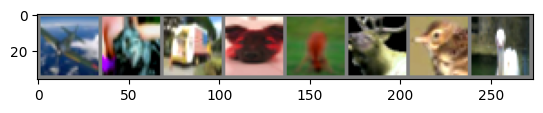

SVHN
       3        2        7        1        7        1        2        9


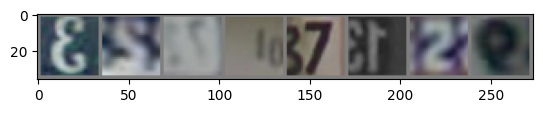

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


cifar_trainloader = DataLoader(cifar_trainset, batch_size=256, shuffle=True)
# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))
plt.show()

print('SVHN')

dataiter = iter(svhn_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join('%8s' % labels[j].item() for j in range(8)))
plt.show()


In [ ]:
learning_rate = 0.001
epochs = 5

model = torchvision.models.resnet18(pretrained = False) # let's initialize a ResNet18 from scratch and pretrain it ourselves
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)

model.to(device)
criterion = nn.CrossEntropyLoss()

# AdamW is an improved gradient descent algorithm
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### Baseline result: Training a ResNet-18 from scratch on SVHN.

In [ ]:
run_training(model, svhn_trainloader, svhn_testloader, criterion = criterion, optimizer = optimizer, num_epochs = epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 102/102 [00:34<00:00,  2.96it/s, Epoch=0, Valid_Acc=24.2, Valid_Loss=2.27]
Validation Accuracy Improved (0.0 ---> 24.21)

100%|██████████| 102/102 [00:35<00:00,  2.91it/s, Epoch=1, Valid_Acc=43.8, Valid_Loss=1.65]
Validation Accuracy Improved (24.21 ---> 43.78)

100%|██████████| 102/102 [00:35<00:00,  2.91it/s, Epoch=2, Valid_Acc=49, Valid_Loss=1.56]
Validation Accuracy Improved (43.78 ---> 49.03)

100%|██████████| 102/102 [00:34<00:00,  2.97it/s, Epoch=3, Valid_Acc=60.3, Valid_Loss=1.21]
Validation Accuracy Improved (49.03 ---> 60.31)

100%|██████████| 102/102 [00:34<00:00,  2.92it/s, Epoch=4, Valid_Acc=65.2, Valid_Loss=1.05]
Validation Accuracy Improved (60.31 ---> 65.19)



## Baseline SVHN result is ... okish?

Can we do better?

YES!

Let's pretrain on CIFAR10 using SimCLR. First, let's define the SimCLR loss (contrastive loss).

Details are not important now. You can read the paper if you want to learn more.

In [ ]:
class SimCLRLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()

        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

# helper stuff
def plot_features(model, dataloader, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for i, (x1,x2) in enumerate(dataloader):
            x1 = x1.squeeze().to(device = device, dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats, out, axis = 0)

            if i == 100:
              break

    tsne = TSNE(n_components = 2, perplexity = 50, verbose = 2)
    x_feats = tsne.fit_transform(feats)

    plt.scatter(x_feats[:, 1], x_feats[:, 0])
    plt.show()

Custom model wrapper to have a projection head.

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class ModelForPretraining(nn.Module):
    def __init__(self, projector_size):
        super().__init__()

        self.pretrained = torchvision.models.resnet18(pretrained=False)

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True

        # TODO probably needs some adjusting, maybe it's too small?
        # TODO instead of a Linear layer, make it a MLP. Check the paper.
        self.projector = nn.Linear(512, projector_size, bias = True)

    def forward(self,x):
        out = self.pretrained(x)
        xp = self.projector(torch.squeeze(out))
        return xp

class ModelForFinetuning(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()

        self.premodel = pretrained_model
        self.num_classes = 10

        # Freeze the layers of the pretrained model

        # TODO Optionally freeze model parameters if you have a good model and train only the last layer
        # for p in self.premodel.parameters():
        #     p.requires_grad = False

        # for p in self.premodel.projector.parameters():
        #     p.requires_grad = False

        # Fine-tune only the last layer
        self.lastlayer = nn.Linear(512, self.num_classes)

    def forward(self,x):
        out = self.premodel.pretrained(x)
        out = self.lastlayer(out)
        return out

# SimCLR training loop
## Augment an image two ways and compute the contrastive loss with respect to the other images in the batch

In [ ]:
class TwoViewsDataset(torch.utils.data.Dataset):
  def __init__(self, source_dataset):
    # WARNING !!!! This assumes the dataset outputs augmented images
    self.source_dataset = source_dataset

  def __len__(self):
    return len(self.source_dataset)

  def __getitem__(self, idx):
    # each time is a different augmentation of the same image
    view1, _ = self.source_dataset[idx]
    view2, _ = self.source_dataset[idx]

    return view1, view2

In [ ]:
cifar_trainloader = DataLoader(TwoViewsDataset(source_dataset = cifar_trainset), batch_size=128, shuffle=True, drop_last = True)
cifar_testloader = DataLoader(TwoViewsDataset(source_dataset = cifar_testset), batch_size=128, shuffle=True, drop_last = True)


# TODO Usually train for a longer time. Way longer.
epochs = 5

model_for_pretraining = ModelForPretraining(projector_size = 256) # TODO might need some changes to the projector_size? Check the paper.
model_for_pretraining.to(device)

# TODO temperature might need some changes. Check the paper.
# TODO the batch size seems important. Usually, for contrastive learning, the bigger the batch size, the better. Check the paper.
criterion = SimCLRLoss(batch_size = 128, temperature = 1.0)
optimizer = optim.AdamW(model_for_pretraining.parameters(), lr=learning_rate)

for epoch in range(epochs):
    print(f"Epoch [{epoch}/{epochs}]\t")
    model_for_pretraining.train()

    for step, (x_i, x_j) in enumerate(tqdm(cifar_trainloader, total = len(cifar_trainloader))):
        optimizer.zero_grad()

        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model_for_pretraining(x_i)
        z_j = model_for_pretraining(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        if nr == 0 and step % 25 == 0:
            print(f"Step [{step}/{len(cifar_trainloader)}]\t Train Loss: {round(loss.item(), 5)}")

    model_for_pretraining.eval()

    # Evaluation
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(tqdm(cifar_testloader, total = len(cifar_testloader))):

          x_i = x_i.squeeze().to(device).float()
          x_j = x_j.squeeze().to(device).float()

          # positive pair, with encoding
          z_i = model_for_pretraining(x_i)
          z_j = model_for_pretraining(x_j)

          loss = criterion(z_i, z_j)

          if nr == 0 and step % 25 == 0:
              print(f"Step [{step}/{len(cifar_testloader)}]\t Val Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    print(f"Epoch [{epoch}/{epochs}]")
    # TODO uncomment this to visualize clustering after each epoch. But it takes a long time time. Maybe do it every k epochs or something.
    # plot_features(model_for_pretraining.pretrained, cifar_testloader, 512, 128)


Epoch [0/15]	


  0%|          | 1/390 [00:00<03:49,  1.69it/s]

Step [0/390]	 Train Loss: 5.51636


  7%|▋         | 26/390 [00:14<03:11,  1.90it/s]

Step [25/390]	 Train Loss: 4.84501


 13%|█▎        | 51/390 [00:27<02:56,  1.92it/s]

Step [50/390]	 Train Loss: 4.81707


 19%|█▉        | 76/390 [00:41<02:42,  1.93it/s]

Step [75/390]	 Train Loss: 4.76481


 26%|██▌       | 101/390 [00:54<02:29,  1.93it/s]

Step [100/390]	 Train Loss: 4.72283


 32%|███▏      | 126/390 [01:08<02:19,  1.90it/s]

Step [125/390]	 Train Loss: 4.7069


 39%|███▊      | 151/390 [01:21<02:06,  1.89it/s]

Step [150/390]	 Train Loss: 4.69672


 45%|████▌     | 176/390 [01:35<02:07,  1.68it/s]

Step [175/390]	 Train Loss: 4.71012


 52%|█████▏    | 201/390 [01:49<01:54,  1.65it/s]

Step [200/390]	 Train Loss: 4.68863


 58%|█████▊    | 226/390 [02:03<01:32,  1.77it/s]

Step [225/390]	 Train Loss: 4.68415


 64%|██████▍   | 251/390 [02:17<01:26,  1.60it/s]

Step [250/390]	 Train Loss: 4.6743


 71%|███████   | 276/390 [02:30<01:02,  1.83it/s]

Step [275/390]	 Train Loss: 4.67213


 77%|███████▋  | 301/390 [02:44<00:47,  1.88it/s]

Step [300/390]	 Train Loss: 4.66185


 84%|████████▎ | 326/390 [02:58<00:33,  1.91it/s]

Step [325/390]	 Train Loss: 4.65994


 90%|█████████ | 351/390 [03:11<00:20,  1.90it/s]

Step [350/390]	 Train Loss: 4.66206


 96%|█████████▋| 376/390 [03:25<00:07,  1.88it/s]

Step [375/390]	 Train Loss: 4.65961


  1%|▏         | 1/78 [00:00<00:26,  2.87it/s]

Step [0/78]	 Test Loss: 4.68083


 33%|███▎      | 26/78 [00:10<00:23,  2.21it/s]

Step [25/78]	 Test Loss: 4.69663


 65%|██████▌   | 51/78 [00:19<00:10,  2.61it/s]

Step [50/78]	 Test Loss: 4.68897


 97%|█████████▋| 76/78 [00:30<00:00,  2.62it/s]

Step [75/78]	 Test Loss: 4.68608


100%|██████████| 78/78 [00:30<00:00,  2.53it/s]


Epoch [0/15]	 Training Loss: 4.7285133826426975
Epoch [0/15]	 Validation Loss: 4.6872675602252665
Epoch [0/15]
Epoch [1/15]	


  0%|          | 1/390 [00:00<03:35,  1.81it/s]

Step [0/390]	 Train Loss: 4.66023


  7%|▋         | 26/390 [00:14<03:12,  1.89it/s]

Step [25/390]	 Train Loss: 4.66137


 13%|█▎        | 51/390 [00:28<03:22,  1.68it/s]

Step [50/390]	 Train Loss: 4.65339


 19%|█▉        | 76/390 [00:42<03:10,  1.65it/s]

Step [75/390]	 Train Loss: 4.65046


 26%|██▌       | 101/390 [00:55<02:41,  1.79it/s]

Step [100/390]	 Train Loss: 4.65392


 32%|███▏      | 126/390 [01:09<02:23,  1.84it/s]

Step [125/390]	 Train Loss: 4.64439


 39%|███▊      | 151/390 [01:22<02:07,  1.87it/s]

Step [150/390]	 Train Loss: 4.64782


 45%|████▌     | 176/390 [01:36<01:53,  1.89it/s]

Step [175/390]	 Train Loss: 4.64096


 52%|█████▏    | 201/390 [01:49<01:38,  1.91it/s]

Step [200/390]	 Train Loss: 4.64311


 58%|█████▊    | 226/390 [02:03<01:25,  1.92it/s]

Step [225/390]	 Train Loss: 4.65172


 64%|██████▍   | 251/390 [02:17<01:20,  1.72it/s]

Step [250/390]	 Train Loss: 4.63584


 71%|███████   | 276/390 [02:30<00:59,  1.92it/s]

Step [275/390]	 Train Loss: 4.64404


 77%|███████▋  | 301/390 [02:44<00:46,  1.91it/s]

Step [300/390]	 Train Loss: 4.656


 84%|████████▎ | 326/390 [02:58<00:37,  1.71it/s]

Step [325/390]	 Train Loss: 4.63449


 90%|█████████ | 351/390 [03:11<00:23,  1.63it/s]

Step [350/390]	 Train Loss: 4.63892


 96%|█████████▋| 376/390 [03:25<00:07,  1.76it/s]

Step [375/390]	 Train Loss: 4.64449


  1%|▏         | 1/78 [00:00<00:27,  2.83it/s]

Step [0/78]	 Test Loss: 4.67627


 33%|███▎      | 26/78 [00:10<00:19,  2.69it/s]

Step [25/78]	 Test Loss: 4.66678


 65%|██████▌   | 51/78 [00:20<00:10,  2.62it/s]

Step [50/78]	 Test Loss: 4.67538


 97%|█████████▋| 76/78 [00:30<00:00,  2.45it/s]

Step [75/78]	 Test Loss: 4.65458


100%|██████████| 78/78 [00:31<00:00,  2.49it/s]


Epoch [1/15]	 Training Loss: 4.647922936463967
Epoch [1/15]	 Validation Loss: 4.673497560696724
Epoch [1/15]
Epoch [2/15]	


  0%|          | 1/390 [00:00<03:50,  1.69it/s]

Step [0/390]	 Train Loss: 4.63295


  7%|▋         | 26/390 [00:14<03:21,  1.81it/s]

Step [25/390]	 Train Loss: 4.63715


 13%|█▎        | 51/390 [00:28<03:03,  1.85it/s]

Step [50/390]	 Train Loss: 4.6344


 19%|█▉        | 76/390 [00:42<02:51,  1.83it/s]

Step [75/390]	 Train Loss: 4.63306


 26%|██▌       | 101/390 [00:56<02:33,  1.88it/s]

Step [100/390]	 Train Loss: 4.63371


 32%|███▏      | 126/390 [01:10<02:20,  1.88it/s]

Step [125/390]	 Train Loss: 4.62647


 39%|███▊      | 151/390 [01:24<02:22,  1.68it/s]

Step [150/390]	 Train Loss: 4.62204


 45%|████▌     | 176/390 [01:38<02:13,  1.61it/s]

Step [175/390]	 Train Loss: 4.63158


 52%|█████▏    | 201/390 [01:52<01:48,  1.74it/s]

Step [200/390]	 Train Loss: 4.63628


 58%|█████▊    | 226/390 [02:06<01:32,  1.77it/s]

Step [225/390]	 Train Loss: 4.6267


 64%|██████▍   | 251/390 [02:20<01:22,  1.68it/s]

Step [250/390]	 Train Loss: 4.63379


 71%|███████   | 276/390 [02:35<01:02,  1.82it/s]

Step [275/390]	 Train Loss: 4.62155


 77%|███████▋  | 301/390 [02:49<00:49,  1.81it/s]

Step [300/390]	 Train Loss: 4.62752


 84%|████████▎ | 326/390 [03:03<00:35,  1.82it/s]

Step [325/390]	 Train Loss: 4.63031


 90%|█████████ | 351/390 [03:18<00:24,  1.60it/s]

Step [350/390]	 Train Loss: 4.62225


 96%|█████████▋| 376/390 [03:33<00:08,  1.62it/s]

Step [375/390]	 Train Loss: 4.63189


  1%|▏         | 1/78 [00:00<00:29,  2.63it/s]

Step [0/78]	 Test Loss: 4.66653


 33%|███▎      | 26/78 [00:11<00:21,  2.47it/s]

Step [25/78]	 Test Loss: 4.62888


 65%|██████▌   | 51/78 [00:21<00:10,  2.47it/s]

Step [50/78]	 Test Loss: 4.66949


 97%|█████████▋| 76/78 [00:32<00:00,  2.46it/s]

Step [75/78]	 Test Loss: 4.65149


100%|██████████| 78/78 [00:33<00:00,  2.34it/s]


Epoch [2/15]	 Training Loss: 4.632074837806897
Epoch [2/15]	 Validation Loss: 4.6487291531685075
Epoch [2/15]
Epoch [3/15]	


  0%|          | 1/390 [00:00<03:41,  1.76it/s]

Step [0/390]	 Train Loss: 4.62772


  7%|▋         | 26/390 [00:14<03:19,  1.83it/s]

Step [25/390]	 Train Loss: 4.62391


 13%|█▎        | 51/390 [00:28<03:05,  1.83it/s]

Step [50/390]	 Train Loss: 4.62179


 19%|█▉        | 76/390 [00:43<02:52,  1.82it/s]

Step [75/390]	 Train Loss: 4.62513


 26%|██▌       | 101/390 [00:57<02:48,  1.72it/s]

Step [100/390]	 Train Loss: 4.62162


 32%|███▏      | 126/390 [01:11<02:47,  1.58it/s]

Step [125/390]	 Train Loss: 4.6233


 39%|███▊      | 151/390 [01:26<02:19,  1.71it/s]

Step [150/390]	 Train Loss: 4.61876


 45%|████▌     | 176/390 [01:40<02:00,  1.77it/s]

Step [175/390]	 Train Loss: 4.6163


 48%|████▊     | 187/390 [01:46<01:55,  1.75it/s]


KeyboardInterrupt: ignored

## Model fine-tuning on 10% of SVHN

In [ ]:
downstream_model = ModelForFinetuning(pretrained_model = model_for_pretraining)
downstream_model.to(device)

criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(downstream_model.parameters(), lr=0.001)

run_training(downstream_model, svhn_trainloader, svhn_testloader, criterion = criterion, optimizer = optimizer, num_epochs = epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 102/102 [00:44<00:00,  2.31it/s, Epoch=0, Valid_Acc=49.6, Valid_Loss=1.52]
Validation Accuracy Improved (0.0 ---> 49.65)

100%|██████████| 102/102 [00:42<00:00,  2.39it/s, Epoch=1, Valid_Acc=70, Valid_Loss=0.93]
Validation Accuracy Improved (49.65 ---> 69.98)

100%|██████████| 102/102 [00:56<00:00,  1.79it/s, Epoch=2, Valid_Acc=72.4, Valid_Loss=0.86]
Validation Accuracy Improved (69.98 ---> 72.38)

100%|██████████| 102/102 [00:45<00:00,  2.23it/s, Epoch=3, Valid_Acc=73.2, Valid_Loss=0.84]
Validation Accuracy Improved (72.38 ---> 73.23)

 17%|█▋        | 5/29 [00:03<00:15,  1.56it/s, Epoch=4, Train_Loss=0.52]


KeyboardInterrupt: ignored

## We have improved results!

#### If not, add more augmentations, pretrain for longer. Check the paper for more insights.